In [33]:
import csv
import numpy as np
import pandas as pd
import matplotlib.style
import matplotlib.pyplot as plt
year = 2020
#dati https://geodati.gov.it:443/geoportalRNDTPA/catalog/search/resource/details.page?uuid=PCM:COVID-19:05032020:093000
#aree https://geodati.gov.it/geoportalRNDTPA/catalog/search/resource/details.page?uuid=PCM:000086:20200306:110700
#dati nazionale https://github.com/pcm-dpc/COVID-19/tree/master/dati-andamento-nazionale
#dati regionale https://github.com/pcm-dpc/COVID-19/tree/master/dati-regioni
#dati province https://github.com/pcm-dpc/COVID-19/tree/master/dati-province
cvs_regionale_fileurl = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
months_days=(('02','24'),('02','25'),('02','26'),('02','27'),('02','28'),('02','29'),
             ('03','01'),('03','02'),('03','03'),('03','04'),('03','05'),('03','06'),
             ('03','07'),('03','08'),('03','09'),('03','10'),('03','11'),('03','12'),
             ('03','13'),('03','14'),('03','15'),('03','16'),('03','17'),('03','18'),
             ('03','19'),('03','20'),('03','21'))

from datetime import datetime
import pytz

local_tz = pytz.timezone('Europe/Rome')
rundate_iso = datetime.now(local_tz).isoformat().replace(':','-') # filename friendly
rundate_print = datetime.now(local_tz).strftime("%Y-%m-%d %H:%M %z CES")

#Population from Wikipedia, retrieved 18.03.2020 , [regional_code, region_name, region_population ]
regions_pd = pd.DataFrame([
    [1,'Piemonte', 4356406],
    [2,"Valle d'Aosta", 125666],
    [3,'Lombardia', 10060574],
    [4,'P.A. Bolzano', 533050],
    [104,'P.A. Trento', 541380],
    [5,'Veneto', 4905854],
    [6,'Friuli Venzia Giulia', 1215220],
    [7,'Liguria', 1550640],
    [8,'Emilia-Romagna', 4459477],
    [9,'Toscana', 3729641],
    [10,'Umbria', 882015],
    [11,'Marche', 1525271],
    [12,'Lazio', 5879082],
    [13,'Abruzzo', 1311580],
    [14,'Molise', 305617],
    [15,'Campania', 5801692],
    [16,'Puglia', 4029053],
    [17,'Basilicata', 562869],
    [18,'Calabria', 1947131],
    [19,'Sicilia', 4999891],
    [20,'Sardegna', 1639591]], columns=['code','region','P']) # P:population


In [93]:
pd.DataFrame([rundate_print]).to_clipboard(index=False,header=False)
print("Current run time: " + rundate_print)

Current run time: 2020-03-24 11:25 +0100 CES


In [25]:
# data,stato,codice_regione,denominazione_regione,lat,long,
# 1.ricoverati_con_sintomi,2.terapia_intensiva, 3. totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
# 2020-02-24 18:00:00,ITA,13,Abruzzo,42.35122196,13.39843823,0,0,0,0,0,0,0,0,0,5
# 2020-02-24 18:00:00,ITA,17,Basilicata,40.63947052,15.80514834,0,0,0,0,0,0,0,0,0,0
dtype_andamento_regionale="datetime64[s],S3,i8,S21,f8,f8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8"


<br>
<br>

## Retrieving and cleaning the dataset

<br>
<br>

In [26]:
rows_np = np.genfromtxt( 
        cvs_regionale_fileurl,
        dtype = dtype_andamento_regionale,
        delimiter=',', 
        names=True)

In [27]:
rows_pd = pd.DataFrame(rows_np)

# Index(['data', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
#        'long', 'ricoverati_con_sintomi', 'terapia_intensiva',
#        'totale_ospedalizzati', 'isolamento_domiciliare',
#        'totale_attualmente_positivi', 'nuovi_attualmente_positivi',
#        'dimessi_guariti', 'deceduti', 'totale_casi', 'tamponi'],
#       dtype='object')

rows_pd.rename(columns={'data':'date',
                        'ricoverati_con_sintomi':'h', #hospitalized
                        'terapia_intensiva':'icu',
                        'totale_ospedalizzati':'h+icu', 
                        'isolamento_domiciliare':'q', #quarantine
                        'totale_attualmente_positivi': 'p', #positives
                        'nuovi_attualmente_positivi': 'np', #new positives
                        'dimessi_guariti':'d', #discharged 
                        'deceduti':'dc', #deceased 
                        'totale_casi':'T', 
                        'tamponi': 'S' #swabs
                       }, inplace=True)

rows_pd.index

RangeIndex(start=0, stop=588, step=1)

In [28]:
# b'P.A. Trento' and b'P.A. Bolzano' both share codice_regione==4 - setting P.A.Trento to 104
rows_pd.loc[rows_pd['denominazione_regione']==b'P.A. Trento','codice_regione']=104
#merge population from regions_pd
rows_pd=pd.merge(rows_pd, regions_pd, how='left', left_on='codice_regione', right_on='code',
         left_index=False, right_index=False, copy=True, 
         validate="m:1")

rows_pd.columns

Index(['date', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
       'long', 'h', 'icu', 'h+icu', 'q', 'p', 'np', 'd', 'dc', 'T', 'S',
       'code', 'region', 'P'],
      dtype='object')

In [29]:
last_day_of_data = rows_pd['date'].max().floor('D')

<br>
<br>
<br>

## Number of tested positives per 100k inhabitants, by region

<br>
<br>
<br>

In [96]:
rows_pd.loc[:,'Tper100kP']=rows_pd['T'].div(rows_pd['P']).mul(100000)

<Figure size 1200x800 with 0 Axes>

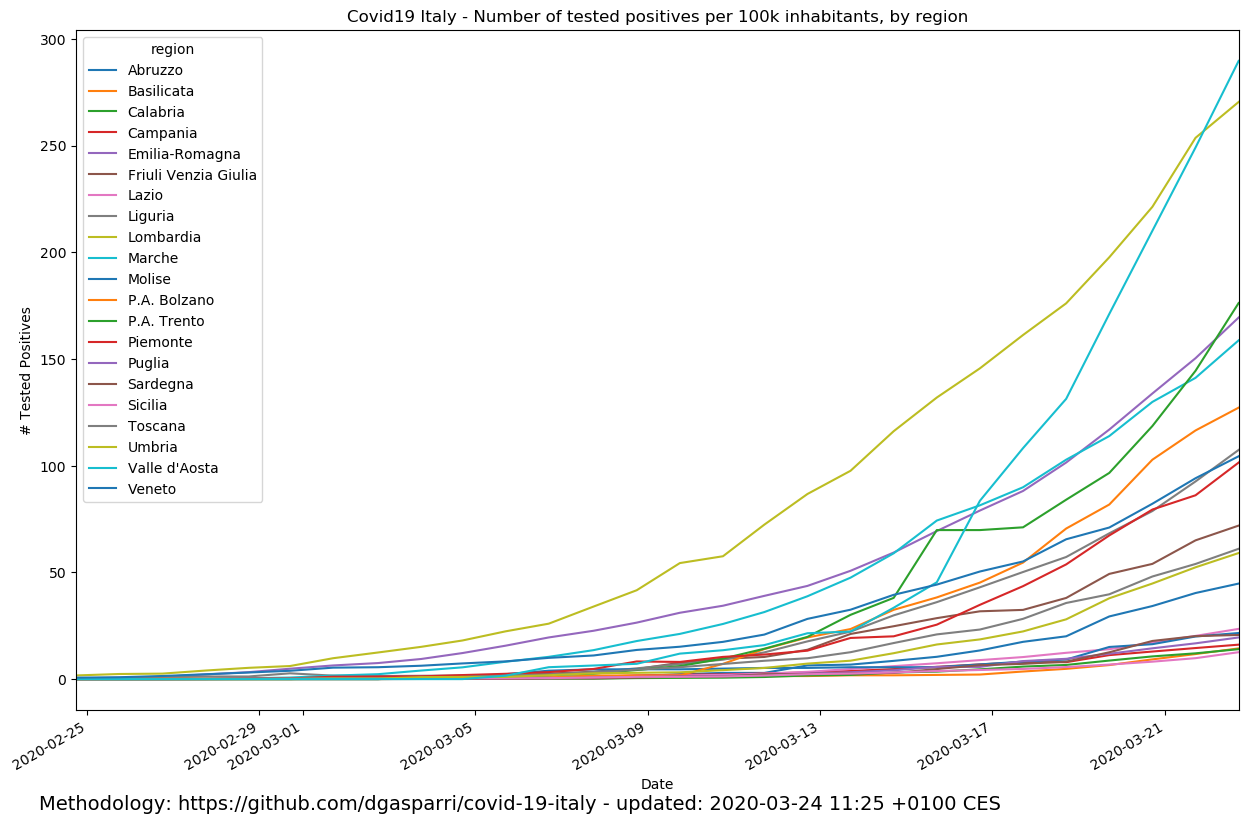

In [97]:
#rows_pd.groupby('code').plot(y='T_over_100kPopulation', x='date')
matplotlib.style.use('default')
fig = plt.figure(figsize=(15,10), dpi=80)
Tper100kP_plt = rows_pd.pivot(index='date',columns='region')['Tper100kP'].plot()
Tper100kP_plt.set_ylabel('# Tested Positives')
Tper100kP_plt.set_xlabel('Date')
Tper100kP_plt.set_title('Covid19 Italy - Number of tested positives per 100k inhabitants, by region')
#fig.add_axes(Tover100k_plt)
Tper100kP_fig = Tper100kP_plt.get_figure()
Tper100kP_fig.set_size_inches(15, 10, forward=True)
Tper100kP_methodology = "Methodology: https://github.com/dgasparri/covid-19-italy - updated: " + rundate_print
Tper100kP_plt.text(0.1, 0.1, Tper100kP_methodology, fontsize=14, transform=plt.gcf().transFigure)
plt.savefig("Tper100kP_"+ rundate_iso + ".png", format='png', dpi=80)


In [98]:
Tover100kP_table = rows_pd.loc[rows_pd['date']>last_day_of_data - pd.Timedelta('7 days')].pivot(index='date',columns='region')['Tper100kP'].T.iloc[:,[0,-1]].round(1)
Tover100kP_table['Growth (linear)'] = Tover100kP_table.iloc[:,1].div(Tover100kP_table.iloc[:,0]).sub(1).mul(100).round(0).astype(str) + '%'
#Tover100kP_table.columns
#Tover100kP_table.sort(columns=Tover100kP_table.columns[1], ascendind=0)
Tover100kP_table = Tover100kP_table.sort_values(by=[Tover100kP_table.columns[1]], ascending=False)
Tover100kP_table

date,2020-03-15 17:00:00,2020-03-22 17:00:00,Growth (linear)
region,,,
Valle d'Aosta,45.4,289.7,538.0%
Lombardia,131.9,270.4,105.0%
P.A. Trento,69.8,176.2,152.0%
Emilia-Romagna,69.4,169.4,144.0%
Marche,74.3,158.7,114.0%
P.A. Bolzano,38.3,127.2,232.0%
Liguria,36.0,107.4,198.0%
Veneto,44.3,104.4,136.0%
Piemonte,25.5,101.5,298.0%


In [99]:
## Print HTML
#pd.DataFrame([Tover100kP_table.to_html()]).to_clipboard(index=False,header=False)
print(Tover100kP_table.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>date</th>
      <th>2020-03-15 17:00:00</th>
      <th>2020-03-22 17:00:00</th>
      <th>Growth (linear)</th>
    </tr>
    <tr>
      <th>region</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Valle d'Aosta</th>
      <td>45.4</td>
      <td>289.7</td>
      <td>538.0%</td>
    </tr>
    <tr>
      <th>Lombardia</th>
      <td>131.9</td>
      <td>270.4</td>
      <td>105.0%</td>
    </tr>
    <tr>
      <th>P.A. Trento</th>
      <td>69.8</td>
      <td>176.2</td>
      <td>152.0%</td>
    </tr>
    <tr>
      <th>Emilia-Romagna</th>
      <td>69.4</td>
      <td>169.4</td>
      <td>144.0%</td>
    </tr>
    <tr>
      <th>Marche</th>
      <td>74.3</td>
      <td>158.7</td>
      <td>114.0%</td>
    </tr>
    <tr>
      <th>P.A. Bolzano</th>
      <td>38.3</td>
      <td>127.2</td>
      <td>232.0%</td>
    </tr>
    <tr>
      <th>Lig

<br>
<br>
<br>

## Number of swabs performed per 100k inhabitants, by region

<br>
<br>
<br>

In [102]:
rows_pd.loc[:,'Sper100kP']=rows_pd['S'].div(rows_pd['P']).mul(100000)

<Figure size 1200x800 with 0 Axes>

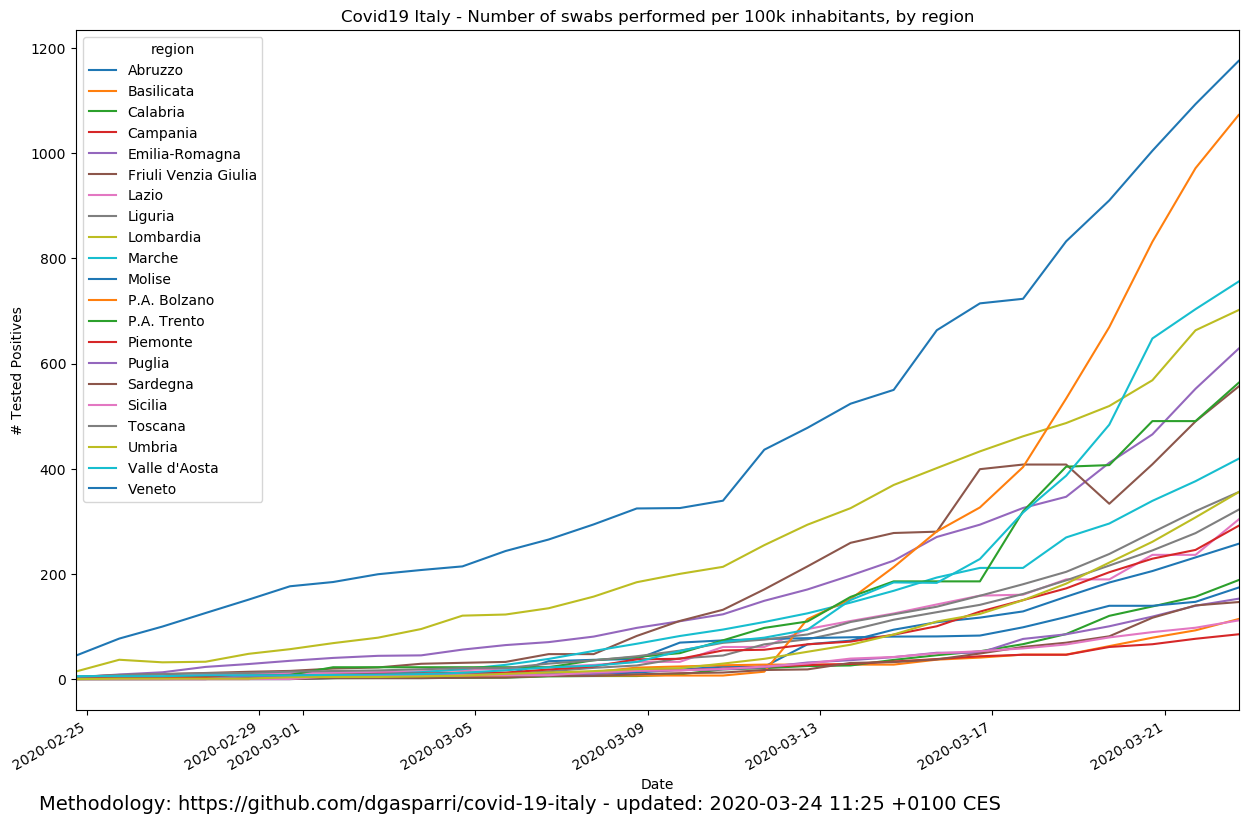

In [103]:
#rows_pd.groupby('code').plot(y='T_over_100kPopulation', x='date')
matplotlib.style.use('default')
fig = plt.figure(figsize=(15,10), dpi=80)
Sper100kP_plt = rows_pd.pivot(index='date',columns='region')['Sper100kP'].plot()
Sper100kP_plt.set_ylabel('# Tested Positives')
Sper100kP_plt.set_xlabel('Date')
Sper100kP_plt.set_title('Covid19 Italy - Number of swabs performed per 100k inhabitants, by region')
#fig.add_axes(Tover100k_plt)
Sper100kP_fig = Sper100kP_plt.get_figure()
Sper100kP_fig.set_size_inches(15, 10, forward=True)
Sper100kP_methodology = "Methodology: https://github.com/dgasparri/covid-19-italy - updated: " + rundate_print
Sper100kP_plt.text(0.1, 0.1, Sper100kP_methodology, fontsize=14, transform=plt.gcf().transFigure)
plt.savefig("Sper100kP_"+ rundate_iso + ".png", format='png', dpi=80)


In [104]:
Sover100kP_table = rows_pd.loc[rows_pd['date']>last_day_of_data - pd.Timedelta('7 days')].pivot(index='date',columns='region')['Sper100kP'].T.iloc[:,[0,-1]].round(1)
Sover100kP_table['Growth (linear)'] = Sover100kP_table.iloc[:,1].div(Sover100kP_table.iloc[:,0]).sub(1).mul(100).round(0).astype(str) + '%'
#Tover100kP_table.columns
#Tover100kP_table.sort(columns=Tover100kP_table.columns[1], ascendind=0)
Sover100kP_table = Sover100kP_table.sort_values(by=[Sover100kP_table.columns[1]], ascending=False)
Sover100kP_table

date,2020-03-15 17:00:00,2020-03-22 17:00:00,Growth (linear)
region,,,
Veneto,663.4,1175.6,77.0%
P.A. Bolzano,280.8,1072.7,282.0%
Valle d'Aosta,183.0,756.0,313.0%
Lombardia,401.3,701.7,75.0%
Emilia-Romagna,270.3,628.4,132.0%
P.A. Trento,185.8,563.4,203.0%
Friuli Venzia Giulia,280.4,556.4,98.0%
Marche,193.1,419.0,117.0%
Toscana,137.6,355.6,158.0%


In [106]:
## Print HTML
pd.DataFrame([Sover100kP_table.to_html()]).to_clipboard(index=False,header=False)
print(Sover100kP_table.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>date</th>
      <th>2020-03-15 17:00:00</th>
      <th>2020-03-22 17:00:00</th>
      <th>Growth (linear)</th>
    </tr>
    <tr>
      <th>region</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Veneto</th>
      <td>663.4</td>
      <td>1175.6</td>
      <td>77.0%</td>
    </tr>
    <tr>
      <th>P.A. Bolzano</th>
      <td>280.8</td>
      <td>1072.7</td>
      <td>282.0%</td>
    </tr>
    <tr>
      <th>Valle d'Aosta</th>
      <td>183.0</td>
      <td>756.0</td>
      <td>313.0%</td>
    </tr>
    <tr>
      <th>Lombardia</th>
      <td>401.3</td>
      <td>701.7</td>
      <td>75.0%</td>
    </tr>
    <tr>
      <th>Emilia-Romagna</th>
      <td>270.3</td>
      <td>628.4</td>
      <td>132.0%</td>
    </tr>
    <tr>
      <th>P.A. Trento</th>
      <td>185.8</td>
      <td>563.4</td>
      <td>203.0%</td>
    </tr>
    <tr>
      <t

<br>
<br>
<br>

## Number of hospitalized (h+icu) per 100k inhabitants, by region

<br>
<br>
<br>

In [110]:
rows_pd.loc[:,'h+icuper100kP']=rows_pd['h+icu'].div(rows_pd['P']).mul(100000)

<Figure size 1200x800 with 0 Axes>

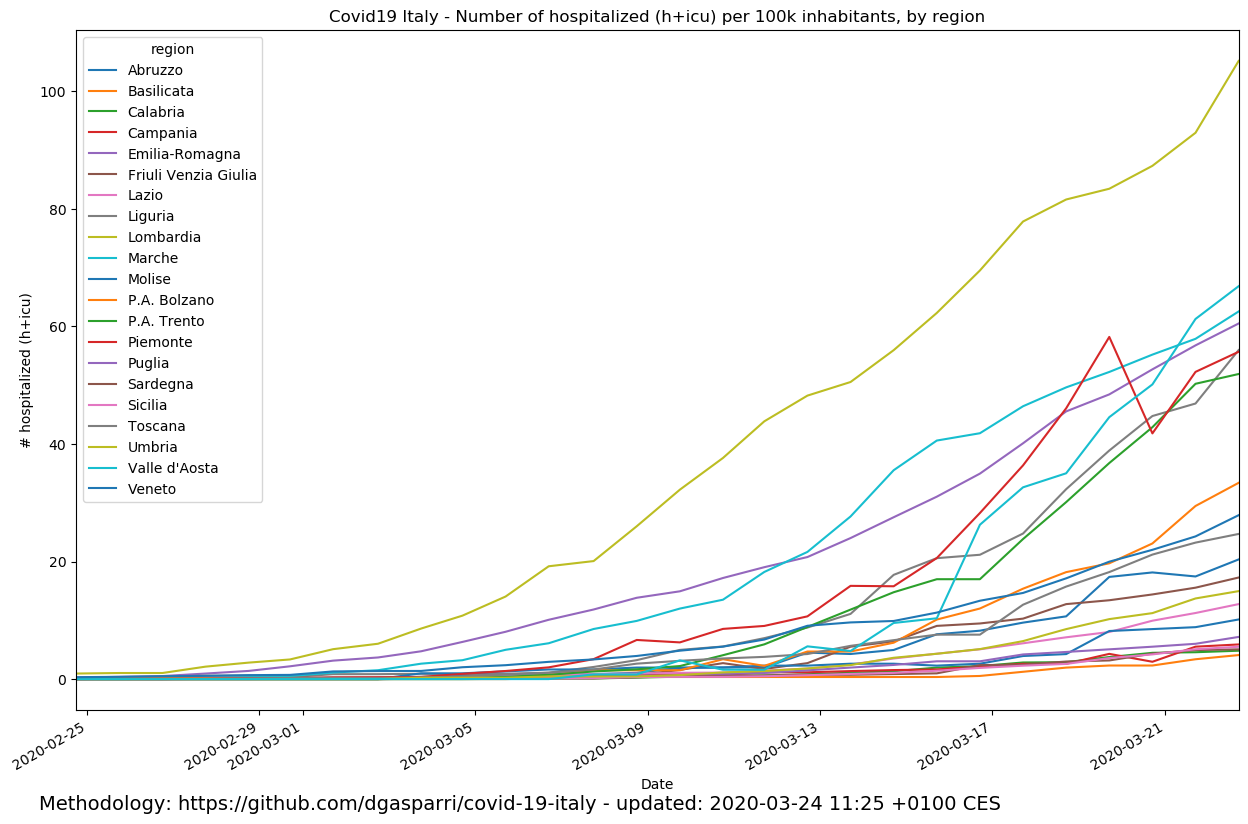

In [111]:
#rows_pd.groupby('code').plot(y='T_over_100kPopulation', x='date')
matplotlib.style.use('default')
fig = plt.figure(figsize=(15,10), dpi=80)
hicuper100kP_plt = rows_pd.pivot(index='date',columns='region')['h+icuper100kP'].plot()
hicuper100kP_plt.set_ylabel('# hospitalized (h+icu)')
hicuper100kP_plt.set_xlabel('Date')
hicuper100kP_plt.set_title('Covid19 Italy - Number of hospitalized (h+icu) per 100k inhabitants, by region')
hicuper100kP_fig = hicuper100kP_plt.get_figure()
hicuper100kP_fig.set_size_inches(15, 10, forward=True)
hicuper100kP_methodology = "Methodology: https://github.com/dgasparri/covid-19-italy - updated: " + rundate_print
hicuper100kP_plt.text(0.1, 0.1, hicuper100kP_methodology, fontsize=14, transform=plt.gcf().transFigure)
plt.savefig("hicuper100kP_"+ rundate_iso + ".png", format='png', dpi=80)


In [112]:
hicuover100kP_table = rows_pd.loc[rows_pd['date']>last_day_of_data - pd.Timedelta('7 days')].pivot(index='date',columns='region')['h+icuper100kP'].T.iloc[:,[0,-1]].round(1)
hicuover100kP_table['Growth (linear)'] = hicuover100kP_table.iloc[:,1].div(hicuover100kP_table.iloc[:,0]).sub(1).mul(100).round(0).astype(str) + '%'
#Tover100kP_table.columns
#Tover100kP_table.sort(columns=Tover100kP_table.columns[1], ascendind=0)
hicuover100kP_table = hicuover100kP_table.sort_values(by=[hicuover100kP_table.columns[1]], ascending=False)
hicuover100kP_table

date,2020-03-15 17:00:00,2020-03-22 17:00:00,Growth (linear)
region,,,
Lombardia,62.3,105.2,69.0%
Valle d'Aosta,10.3,66.8,549.0%
Marche,40.6,62.5,54.0%
Emilia-Romagna,31.0,60.5,95.0%
Liguria,20.6,56.0,172.0%
Piemonte,20.6,55.7,170.0%
P.A. Trento,17.0,51.9,205.0%
P.A. Bolzano,10.1,33.4,231.0%
Veneto,11.3,27.9,147.0%


In [113]:
## Print HTML
#pd.DataFrame([hicuover100kP_table.to_html()]).to_clipboard(index=False,header=False)
print(hicuover100kP_table.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>date</th>
      <th>2020-03-15 17:00:00</th>
      <th>2020-03-22 17:00:00</th>
      <th>Growth (linear)</th>
    </tr>
    <tr>
      <th>region</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Lombardia</th>
      <td>62.3</td>
      <td>105.2</td>
      <td>69.0%</td>
    </tr>
    <tr>
      <th>Valle d'Aosta</th>
      <td>10.3</td>
      <td>66.8</td>
      <td>549.0%</td>
    </tr>
    <tr>
      <th>Marche</th>
      <td>40.6</td>
      <td>62.5</td>
      <td>54.0%</td>
    </tr>
    <tr>
      <th>Emilia-Romagna</th>
      <td>31.0</td>
      <td>60.5</td>
      <td>95.0%</td>
    </tr>
    <tr>
      <th>Liguria</th>
      <td>20.6</td>
      <td>56.0</td>
      <td>172.0%</td>
    </tr>
    <tr>
      <th>Piemonte</th>
      <td>20.6</td>
      <td>55.7</td>
      <td>170.0%</td>
    </tr>
    <tr>
      <th>P.A. Trento</th>
   

<br>
<br>
<br>

## Number of ICU patients per 100k inhabitants, by region

<br>
<br>
<br>

In [120]:
rows_pd.loc[:,'icuper100kP']=rows_pd['icu'].div(rows_pd['P']).mul(100000)

<Figure size 1200x800 with 0 Axes>

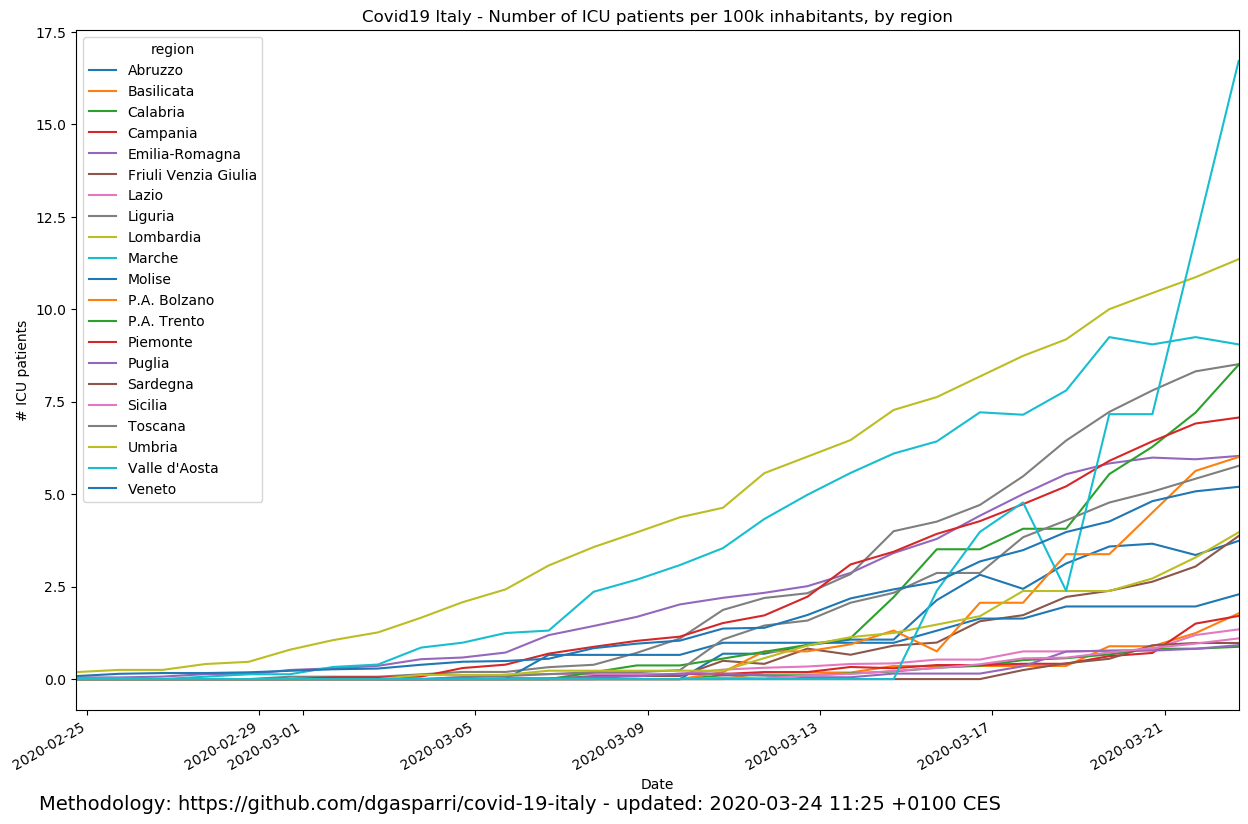

In [116]:
#rows_pd.groupby('code').plot(y='T_over_100kPopulation', x='date')
matplotlib.style.use('default')
fig = plt.figure(figsize=(15,10), dpi=80)
icuper100kP_plt = rows_pd.pivot(index='date',columns='region')['icuper100kP'].plot()
icuper100kP_plt.set_ylabel('# ICU patients')
icuper100kP_plt.set_xlabel('Date')
icuper100kP_plt.set_title('Covid19 Italy - Number of ICU patients per 100k inhabitants, by region')
icuper100kP_fig = icuper100kP_plt.get_figure()
icuper100kP_fig.set_size_inches(15, 10, forward=True)
icuper100kP_methodology = "Methodology: https://github.com/dgasparri/covid-19-italy - updated: " + rundate_print
icuper100kP_plt.text(0.1, 0.1, icuper100kP_methodology, fontsize=14, transform=plt.gcf().transFigure)
plt.savefig("icuper100kP_"+ rundate_iso + ".png", format='png', dpi=80)


In [117]:
icuover100kP_table = rows_pd.loc[rows_pd['date']>last_day_of_data - pd.Timedelta('7 days')].pivot(index='date',columns='region')['icuper100kP'].T.iloc[:,[0,-1]].round(1)
icuover100kP_table['Growth (linear)'] = icuover100kP_table.iloc[:,1].div(icuover100kP_table.iloc[:,0]).sub(1).mul(100).round(0).astype(str) + '%'
icuover100kP_table = icuover100kP_table.sort_values(by=[icuover100kP_table.columns[1]], ascending=False)
icuover100kP_table

date,2020-03-15 17:00:00,2020-03-22 17:00:00,Growth (linear)
region,,,
Valle d'Aosta,2.4,16.7,596.0%
Lombardia,7.6,11.4,50.0%
Marche,6.4,9.0,41.0%
P.A. Trento,3.5,8.5,143.0%
Liguria,4.3,8.5,98.0%
Piemonte,3.9,7.1,82.0%
Emilia-Romagna,3.8,6.0,58.0%
P.A. Bolzano,0.8,6.0,650.0%
Toscana,2.9,5.8,100.0%


In [118]:
## Print HTML
pd.DataFrame([icuover100kP_table.to_html()]).to_clipboard(index=False,header=False)
print(icuover100kP_table.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>date</th>
      <th>2020-03-15 17:00:00</th>
      <th>2020-03-22 17:00:00</th>
      <th>Growth (linear)</th>
    </tr>
    <tr>
      <th>region</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Valle d'Aosta</th>
      <td>2.4</td>
      <td>16.7</td>
      <td>596.0%</td>
    </tr>
    <tr>
      <th>Lombardia</th>
      <td>7.6</td>
      <td>11.4</td>
      <td>50.0%</td>
    </tr>
    <tr>
      <th>Marche</th>
      <td>6.4</td>
      <td>9.0</td>
      <td>41.0%</td>
    </tr>
    <tr>
      <th>P.A. Trento</th>
      <td>3.5</td>
      <td>8.5</td>
      <td>143.0%</td>
    </tr>
    <tr>
      <th>Liguria</th>
      <td>4.3</td>
      <td>8.5</td>
      <td>98.0%</td>
    </tr>
    <tr>
      <th>Piemonte</th>
      <td>3.9</td>
      <td>7.1</td>
      <td>82.0%</td>
    </tr>
    <tr>
      <th>Emilia-Romagna</th>
      <td>3.8</

<br>
<br>
<br>

## Number of h patients per 100k inhabitants, by region

<br>
<br>
<br>

In [119]:
rows_pd.loc[:,'hper100kP']=rows_pd['h'].div(rows_pd['P']).mul(100000)

<Figure size 1200x800 with 0 Axes>

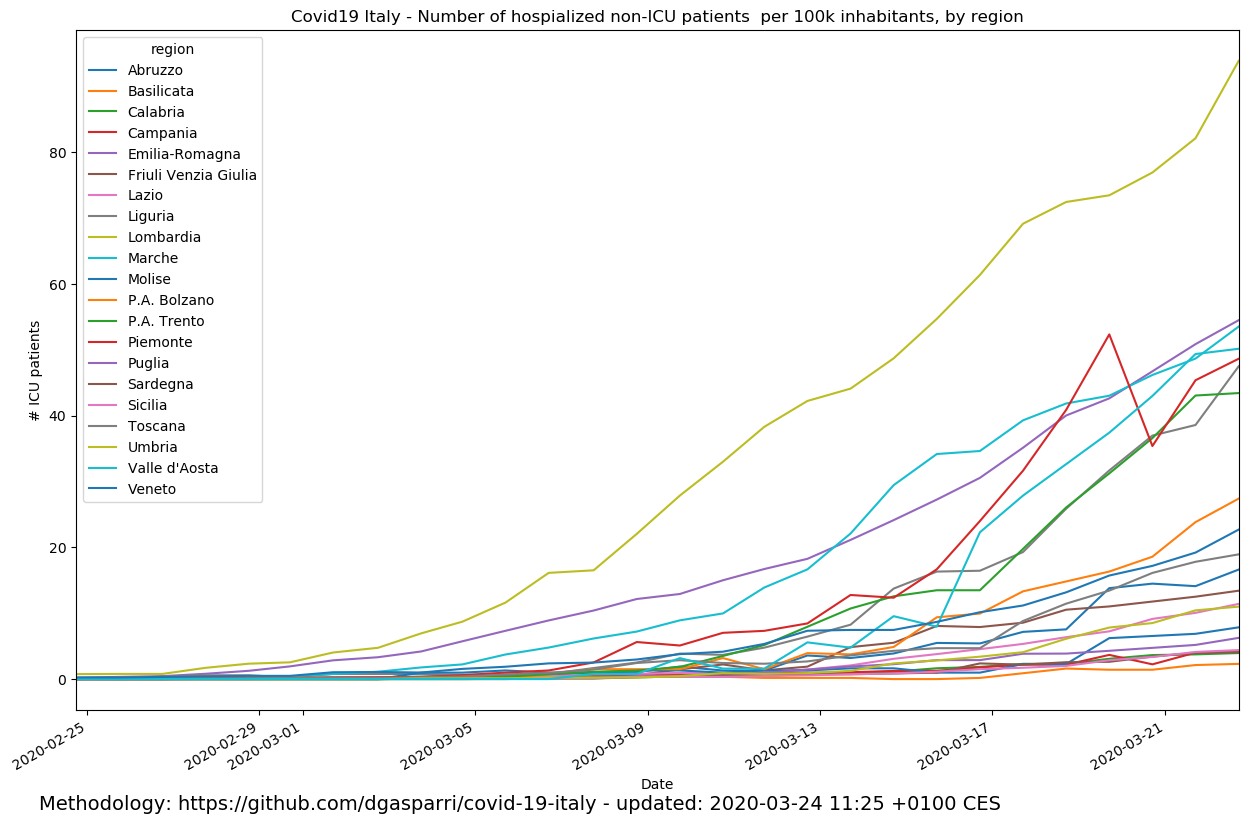

In [121]:
matplotlib.style.use('default')
fig = plt.figure(figsize=(15,10), dpi=80)
hper100kP_plt = rows_pd.pivot(index='date',columns='region')['hper100kP'].plot()
hper100kP_plt.set_ylabel('# ICU patients')
hper100kP_plt.set_xlabel('Date')
hper100kP_plt.set_title('Covid19 Italy - Number of hospialized non-ICU patients  per 100k inhabitants, by region')
hper100kP_fig = hper100kP_plt.get_figure()
hper100kP_fig.set_size_inches(15, 10, forward=True)
hper100kP_methodology = "Methodology: https://github.com/dgasparri/covid-19-italy - updated: " + rundate_print
hper100kP_plt.text(0.1, 0.1, hper100kP_methodology, fontsize=14, transform=plt.gcf().transFigure)
plt.savefig("hper100kP_"+ rundate_iso + ".png", format='png', dpi=80)


In [122]:
hover100kP_table = rows_pd.loc[rows_pd['date']>last_day_of_data - pd.Timedelta('7 days')].pivot(index='date',columns='region')['hper100kP'].T.iloc[:,[0,-1]].round(1)
hover100kP_table['Growth (linear)'] = hover100kP_table.iloc[:,1].div(hover100kP_table.iloc[:,0]).sub(1).mul(100).round(0).astype(str) + '%'
hover100kP_table = hover100kP_table.sort_values(by=[hover100kP_table.columns[1]], ascending=False)
hover100kP_table

date,2020-03-15 17:00:00,2020-03-22 17:00:00,Growth (linear)
region,,,
Lombardia,54.7,93.8,71.0%
Emilia-Romagna,27.2,54.5,100.0%
Marche,34.2,53.5,56.0%
Valle d'Aosta,8.0,50.1,526.0%
Piemonte,16.7,48.6,191.0%
Liguria,16.3,47.5,191.0%
P.A. Trento,13.5,43.4,221.0%
P.A. Bolzano,9.4,27.4,191.0%
Veneto,8.7,22.7,161.0%


In [123]:
## Print HTML
pd.DataFrame([hover100kP_table.to_html()]).to_clipboard(index=False,header=False)
print(hover100kP_table.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>date</th>
      <th>2020-03-15 17:00:00</th>
      <th>2020-03-22 17:00:00</th>
      <th>Growth (linear)</th>
    </tr>
    <tr>
      <th>region</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Lombardia</th>
      <td>54.7</td>
      <td>93.8</td>
      <td>71.0%</td>
    </tr>
    <tr>
      <th>Emilia-Romagna</th>
      <td>27.2</td>
      <td>54.5</td>
      <td>100.0%</td>
    </tr>
    <tr>
      <th>Marche</th>
      <td>34.2</td>
      <td>53.5</td>
      <td>56.0%</td>
    </tr>
    <tr>
      <th>Valle d'Aosta</th>
      <td>8.0</td>
      <td>50.1</td>
      <td>526.0%</td>
    </tr>
    <tr>
      <th>Piemonte</th>
      <td>16.7</td>
      <td>48.6</td>
      <td>191.0%</td>
    </tr>
    <tr>
      <th>Liguria</th>
      <td>16.3</td>
      <td>47.5</td>
      <td>191.0%</td>
    </tr>
    <tr>
      <th>P.A. Trento</th>
    

<br>
<br>
<br>

# Analysis

<br>
<br>
<br>

In [154]:
rows_pd.columns

Index(['date', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
       'long', 'h', 'icu', 'h+icu', 'q', 'p', 'np', 'd', 'dc', 'T', 'S',
       'code', 'region', 'P', 'Tper100kP', 'Sper100kP', 'h+icuper100kP',
       'icuper100kP', 'hper100kP'],
      dtype='object')

In [128]:
per100k_pd = rows_pd.drop(axis=1,labels=['stato','codice_regione','denominazione_regione','lat','long','h','icu','h+icu','q','p','np','d','dc','T','S','P'])

In [173]:
last_per100k_pd=pd.DataFrame(per100k_pd.loc[rows_pd['date']>last_day_of_data].round(1).drop(axis=1,labels=['date','code']))

#baseline

baseline_pd = pd.DataFrame([['baseline',
                        last_per100k_pd.loc[:,'Tper100kP'].mean(),
                        last_per100k_pd.loc[:,'Sper100kP'].mean(),
                        last_per100k_pd.loc[:,'h+icuper100kP'].mean(),
                        last_per100k_pd.loc[:,'icuper100kP'].mean(),
                        last_per100k_pd.loc[:,'hper100kP'].mean()
                       ]], columns=['region', 
                                    'Tper100kP', 
                                    'Sper100kP', 
                                    'h+icuper100kP',
                                    'icuper100kP',
                                    'hper100kP']).round(0)
last_per100k_pd = last_per100k_pd.append(baseline_pd)

last_per100k_pd.rename(columns={'Tper100kP':'Tested Positive',
                        'Sper100kP':'Covid-19 Swabs', #hospitalized
                        'icuper100kP':'Hospitalized (ICU)',
                        'h+icuper100kP':'Hospitalized (all)', 
                        'hper100kP':'Hospitalized (non-ICU)', #quarantine
                       }, inplace=True)
last_per100k_pd

,region,Tested Positive,Covid-19 Swabs,Hospitalized (all),Hospitalized (ICU),Hospitalized (non-ICU)
567,Abruzzo,44.8,257.3,20.4,3.7,16.6
568,Basilicata,14.4,114.2,4.1,1.8,2.3
569,P.A. Bolzano,127.2,1072.7,33.4,6.0,27.4
570,Calabria,14.0,188.3,4.8,0.9,4.0
571,Campania,16.1,85.2,5.9,1.7,4.2
572,Emilia-Romagna,169.4,628.4,60.5,6.0,54.5
573,Friuli Venzia Giulia,71.9,556.4,17.3,3.9,13.4
574,Lazio,23.5,303.5,12.8,1.3,11.4
575,Liguria,107.4,322.1,56.0,8.5,47.5
576,Lombardia,270.4,701.7,105.2,11.4,93.8


In [174]:
## Print HTML
pd.DataFrame([last_per100k_pd.to_html()]).to_clipboard(index=False,header=False)
#print(hover100kP_table.to_html())

In [159]:
last_per100k_extract_pd= last_per100k_pd.loc[last_per100k_pd['region'].isin(['Valle d\'Aosta','Lombardia','P.A. Trento','Marche','Emilia-Romagna'])]
last_per100k_extract_pd

,region,Testati Positivi,Tamponi,Ricoverati,Ricoverati in ICU,Ricoverati non-ICU
572,Emilia-Romagna,169.4,628.4,60.5,6.0,54.5
576,Lombardia,270.4,701.7,105.2,11.4,93.8
577,Marche,158.7,419.0,62.5,9.0,53.5
584,P.A. Trento,176.2,563.4,51.9,8.5,43.4
586,Valle d'Aosta,289.7,756.0,66.8,16.7,50.1
